# YOUR PROJECT TITLE

Imports and set magics:

In [1]:
import numpy as np
from scipy import optimize
from scipy import linalg
from scipy import interpolate 
import sympy as sm
import mpmath as mp

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject

In [2]:
%matplotlib inline 
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

## Intertemporal consumer optimization

First we consider consumer with **utility function** under period t and  where:

**utility** is given by $$u(c_t) = \frac{c^{1-\theta}}{1-\theta} $$.

suppose consumer can live two periods: today and tomorrow, with the discount factor $\beta$, consumer's lifelong utility is:

$$ u(c_0,c_1) = \frac{c_0^{1-\theta}}{1-\theta} + \beta \frac{c_1^{1-\theta}}{1-\theta} $$

the customer is trying to solve utility maximization problem with **intertemporal budet constraint**

$$ c_0 + \frac{c_1}{1+r} = w_0 + \frac{w_1}{1+r} $$

where $w_0$ is the income for today, $w_1$ is the income tomorrow, r is discount rate

In [3]:
# define parameter values
theta = 0.4 
beta = 0.7
w0 = 20 
w1 = 10
r = 0.05

From FOC we have $$ c_0^{-\theta} = \beta(1+r)c_1^{-\theta} $$
$$ c_0 + \frac{c_1}{1+r} = w_0 + \frac{w_1}{1+r} $$

In [4]:
# Define implicit functions using result from the FOC
def function_0(c0, c1): 
    """
    
    Implicit function derived from the Euler equation.
    """
    return c0**(-theta)-beta*(1+r)*c1**(-theta)
    
def function_1(c0, c1): 
    """
    
    Implicit function derived from the budget constraint.
    """
    return w0+(1/(1+r))*w1-c0-(1/(1+r))*c1


In [5]:
# Fefine a function that optimize consumption bundle
def optimal_bundle(X):
    result = [function_0(X[0], X[1])]
    result.append(function_1(X[0], X[1]))
    return result

# Apply fsolve()...note that we need to give the algorithm a decent guess!
c0_initial, c1_initial = 1, 1
c0_star, c1_star = optimize.fsolve(func=optimal_bundle, x0=(c0_initial, c1_initial))

In [6]:
print ("Optimal choice of c0 is:", c0_star)
print ("Optimal choice of c1 is:", c1_star)

Optimal choice of c0 is: 20.487111357724327
Optimal choice of c1 is: 9.48853307438946


## Ramsey Model

We consider the **Ramsey Model** from macro 3, in which we have sectors:

**Households** own capital, supply labor and consume
**Firm** give out capital and hire labor for production

there are 4 variables
**capital**: ${K_t}$
**labor**: ${L_t}$
**output**: ${Y_t}$
**consumption**: ${C_t}$

for individuals there are
output per capita ${y_t}$ = ${Y_t}$/ ${L_t}$, capital per capita ${k_t}$ = ${K_t}$/${L_t}$, consumption per capita ${c_t}$ = ${C_t}$/${L_t}$

**prices** are taken as given by households and firms 
${r_t}$: capital rent rate
${w_t}$: wage rate

return on capital owned by households, depreciation rate $\delta$>0
$$ {R_t} = 1 + {r_t} - {\delta} $$

**Firms** production function is given by:
$$ Y_t = F(K_t,L_t) = f(k_t)L_t $$

Firm profit maximization:
$$ max_{k_t,l_t} f(k_t)L_t - r_tK_t - w_tL_t $$

With FOC
$$ f'(k_t) = r_t $$
$$ f(k_t) - f'(k_t)k_t = w_t $$

consider the case with **Cobb-Douglas Production** function:
$$ F(K_t,L_t) = AK^{\alpha}L^{1-\alpha} $$

$$f(k_t) = Ak_t^{\alpha} $$

and now $$ r_t = A{\alpha}k_t^{\alpha-1}$$, $$w_t=  A(1-\alpha)k_t^{\alpha} $$

**Households** maximize utility from consumption:
$$ max_{c_t} \sum_{t=0}^{\infty} \beta^t u(c_t), u'>0, u''<0 $$ 

under resource constraint 
$$ k_{t+1} = R_tk_t + w_t - c_t $$

with given $k_0 $, $ ({R_t})_{t=0}^{\infty} $ and  $ ({w_t})_{t=0}^{\infty} $

euler equation $$\frac{u'(c_t)}{u'(c_{t+1})} = \beta{R_{t+1}} $$

set $\theta$ = 1 thus *CRRA utility* function becomes $$u(c_t) = \log( c_t )$$

## Analytical solution for Steady State

First we define all **symbols**:

In [7]:
u = sm.symbols('u')
c0 = sm.symbols('c_t')
c1 = sm.symbols('c_{t+1}')
beta = sm.symbols('beta')
R = sm.symbols('R_{t+1}')
r = sm.symbols('r_t')
delta = sm.symbols('delta')
A = sm.symbols('A')
alpha = sm.symbols('alpha')
k = sm.symbols('k_t')
w = sm.symbols('w_t')
k_star = sm.symbols('k^*')
c_star = sm.symbols('c^*')

r = A*alpha* k **(alpha-1)
w = A*(1-alpha)*k**alpha
R = 1 + r - delta
k1 = R*k + w - c0

utility function of 2 time period 

In [8]:
u0 = sm.log(c0)
u1 = sm.log(c1)

derive euler equation 

In [9]:
euler = sm.Eq(sm.diff(u0,c0)/sm.diff(u1,c1), beta*R)
euler

Eq(c_{t+1}/c_t, beta*(A*alpha*k_t**(alpha - 1) - delta + 1))

solve euler equation 

In [10]:
sol = sm.solve(euler, c1)
sm.Eq(c1,sol[0])

Eq(c_{t+1}, beta*c_t*(A*alpha*k_t**(alpha - 1) - delta + 1))

when under steady state $c_t = c_{t+1}$, $k_t = k_{t+1}$, thus

In [11]:
c_steadystate = sm.Eq(sol[0],c0)
c_steadystate

Eq(beta*c_t*(A*alpha*k_t**(alpha - 1) - delta + 1), c_t)

In [12]:
c_sol = sm.solve(c_steadystate,k)

In [13]:
sm.Eq(k_star,c_sol[0])

Eq(k^*, ((beta*(delta - 1) + 1)/(A*alpha*beta))**(1/(alpha - 1)))

Then we define the **steady state capital**

In [14]:
k_steadystate = sm.Eq(k,k1)
k_steadystate

Eq(k_t, A*k_t**alpha*(1 - alpha) - c_t + k_t*(A*alpha*k_t**(alpha - 1) - delta + 1))

and **solve** it

In [15]:
k_sol = sm.solve(k_steadystate,c0)[0]
sm.Eq(c_star,k_sol)

Eq(c^*, A*k_t**alpha - delta*k_t)

Define the model **parameters**:

In [16]:
A = 1
alpha = 0.4
delta = 0.1
beta = 0.7

## Numerical solution

In [17]:
# define production function:
def f(k):

    return A*k**alpha

# define wage rate:
def w(k):

    return A*(1-alpha)*k**alpha

# define return on capital
def R(k):
    
    return 1+ A*(1-alpha)*k**(alpha-1) - delta

define function which calculates the period 1 capital stock per capita.

In [18]:
def capital(k,c):
    """
    Input:
        k_t: period_0 capital per capita
        c_t: period_0 consumption per capita
        
    Return:
        k_t+1: period_1 capital per capita
    """  
    return (R(k))*k - w(k) - c

define a function which calculates the period 1 consumption derived form euler equation.

In [19]:
def consumption(k,c):
    """
    Input:
        k_t: period_0 capital per capita
        c_t: period_0 consumption per capita
        
    Return:
        c_t+1: period_1 consumption per capita        
    """  
    return beta*c*R(k)

define a function in which func_1, func_2= 0 in steady state

In [20]:
# function 1 express the change in capital stock per capita between 2 periods.
def func_1(k,c):
    return capital(k,c) - k

# when under steady state capital(k,c) - k = 0 

In [21]:
# function 2 express the change in consumption per capita between 2 periods
def func_2(k,c):
    return consumption(k,c) - c

# when under steady state consumption(k,c) - c = 0

In [22]:
def steadystate(x):
    result = [func_1(x[0],x[1])]
    result.append(func_2(x[0],x[1]))
    return result

In [23]:
# make initial guess
k0,c0 = 5,5

# imply solver to calculate steady state
k_star, c_star = optimize.fsolve(steadystate,x0=(k0,c0))

print ("Numeric k*:  ", k_star)
print ("Numeric c*:  ", c_star)

Numeric k*:   5.0
Numeric c*:   5.0


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
//anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


define functions with capital k and consumption c on steady state:

In [24]:
# define steady state capital k _star
def k_star():
    return ((beta*(delta-1) + 1)/(A*alpha*beta))**(1/(alpha-1))

# steady state consumption c_star
def c_star():
    return A*k_star()** alpha - delta*k_star()

In [25]:
print ("Analytic k*:", k_star())
print ("Analytic c*:", c_star())

Analytic k*: 0.6284352134762944
Analytic c*: 0.7675887250317597


In [26]:
# steady state production and saving
y_star = f(k_star())
s_star = (y_star - c_star())/ y_star
print ("steady state y*",y_star)
print ("steady state s*",s_star)

steady state y* 0.8304322463793891
steady state s* 0.07567567567567561


## Visualization 

In [27]:
#  locus for capital
def locus(k):
    return f(k) - delta*k

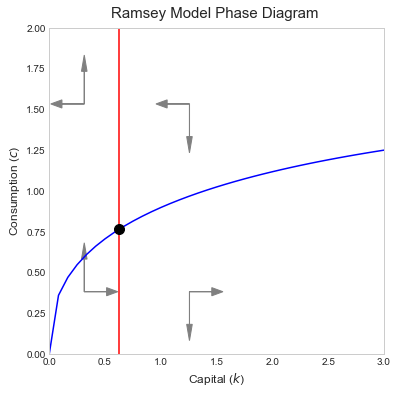

In [31]:
#  create a grid for plotting
xs = np.linspace(0, 500, 6000)

#  Constructing the generic phase diagram 
phase = plt.figure(figsize=(6,6))
plt.xlim(0,3)
plt.ylim(0,2)
plt.grid(False)
plt.xlabel([])

#  Adding the capital and consumption locii
plt.plot(xs, locus(xs), linestyle ='-', color='blue') 
plt.axvline(k_star(), linestyle = '-', color = 'red')
plt.plot(k_star(), c_star(), marker='o', markersize = 10, color ='black')

#  Adding arrows to indicate dynamics 
plt.arrow((1/2)*k_star(), (1/2)*c_star(), dx=0, dy=0.2, head_width = 0.05, head_length= 0.1, color = 'grey')
plt.arrow((1/2)*k_star(), (1/2)*c_star(), dx=0.2, dy=0, head_width = 0.05, head_length= 0.1, color = 'grey')
plt.arrow((1/2)*k_star(), 2*c_star(), dx=0, dy=0.2, head_width = 0.05, head_length= 0.1, color = 'grey')
plt.arrow((1/2)*k_star(), 2*c_star(), dx=-0.2, dy=0, head_width = 0.05, head_length= 0.1, color = 'grey')

plt.arrow(2*k_star(), (1/2)*c_star(), dx=0, dy=-0.2, head_width = 0.05, head_length = 0.1, color = 'grey')
plt.arrow(2*k_star(), (1/2)*c_star(), dx=0.2, dy=0, head_width = 0.05, head_length = 0.1, color = 'grey')
plt.arrow(2*k_star(), 2*c_star(), dx=0, dy=-0.2, head_width = 0.05, head_length = 0.1, color = 'grey')
plt.arrow(2*k_star(), 2*c_star(), dx=-0.2, dy=0, head_width = 0.05, head_length = 0.1, color = 'grey')

#  Adding axis labels and title
plt.xlabel('Capital (${k}$)', fontsize = 12)
plt.ylabel('Consumption (${c}$)', fontsize = 12)
plt.title('Ramsey Model Phase Diagram ', fontsize=15, pad = 10)
plt.show()

# Conclusion

ADD CONCISE CONCLUSION.